# NYC Housing Data 2003-2019

## Описание проекта

Набор данных содержит информацию о ценах на жилье в Нью-Йорке на основе данных за последние 17 лет. Данные из открытых источников Департамента финансов Нью-Йорка.

### Постановка бизнес задачи

Допустим у нас есть платформа, которая является базой объявлений об аренде и продаже недвижимости. Одним из вариантов получения прибыли является риелторская коммиссия с суммы продажи или аренды. В этом случае целесообразно разработать модель, которая сможет определить рыночную стоимость продажи или аренды интересующей недвижимости. Определение стоимости защитит платформу и ее пользователей от недобросовестных клиентов, которые заинтересованы в занижении или завышении цены. Предсказание стоимости само по себе также можно использовать как коммерческую услугу.

### Математическая постановки задачи

Такая бизнес-цель требует построения модели регрессионного анализа. Так как цены на жилье меняются из года в год, для построения поддержания работоспособности модели необходимо обучать ее на актульных данных. Оптимальной метрикой качества для данной задачи, на мой взгляд, является RMSE, стремящееся к нулю. Для интерпретации результатов работы модели воспользуемся метрикой MAE.

## Загрузка библиотек и настроек

In [1]:
import os
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

#from pandas_profiling import ProfileReport

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## Загрузка данных и предпоказ

In [4]:
path = r'd:\Мои документы\datasets\mtc\NYC Housing Data 2003-2019'

file_name = 'data.csv'
profiling_title = 'Profiling NYC Housing Data 2003-2019'
try:
    os.makedirs(os.path.join(path, profiling_title))
    df = pd.read_csv(os.path.join(path, file_name), parse_dates=['SALE DATE'])
except:
    df = pd.read_csv(os.path.join(path, file_name), parse_dates=['SALE DATE'])

In [5]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,02 TWO FAMILY HOMES,746 EAST 6 STREET,10009.0,2134.0,3542.0,1899.0,1800000,2003-01-22
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,316 EAST 3 STREET,10009.0,5746.0,2700.0,1900.0,0,2003-12-18
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,316 EAST 3 STREET,10009.0,5746.0,2700.0,1900.0,0,2003-12-18
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,125 AVENUE D,10009.0,2185.0,5725.0,1910.0,426000,2003-10-23
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,610 EAST 9 STREET,10009.0,2543.0,11568.0,1910.0,0,2003-02-28


## Profiling

In [6]:
#profile = ProfileReport(df, title=profiling_title)
#profile.to_file(output_file=os.path.join(path, profiling_title, "profiling_report.html"))

## Предобработка данных

In [7]:
display(HTML(f'В таблице строк: <code>{df.shape[0]:,.0f}</code>, столбцов: <code>{df.shape[1]}</code>'))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600202 entries, 0 to 1600201
Data columns (total 10 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   BOROUGH                  1600202 non-null  int64         
 1   NEIGHBORHOOD             1600202 non-null  object        
 2   BUILDING CLASS CATEGORY  1600202 non-null  object        
 3   ADDRESS                  1600202 non-null  object        
 4   ZIP CODE                 1600186 non-null  float64       
 5   LAND SQUARE FEET         1582975 non-null  float64       
 6   GROSS SQUARE FEET        1582976 non-null  float64       
 7   YEAR BUILT               1594175 non-null  float64       
 8   SALE PRICE               1600202 non-null  int64         
 9   SALE DATE                1600202 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 122.1+ MB


### Удаление дубликатов

In [9]:
df.drop_duplicates(inplace=True, ignore_index=True)

### Создание отложенной выборки для оценки экономической выгоды

In [10]:
df, df_test = train_test_split(df, test_size=10000, random_state=12345)

### Выделение категориальных и числовых признаков

In [11]:
category_columns = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'ADDRESS', 'ZIP CODE']
numeric_columns = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE']

In [12]:
#df = df.reset_index(drop=True)
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
647963,4,SO. JAMAICA-BAISLEY PARK,01 ONE FAMILY HOMES,150-26 116TH ROAD,11434.0,2000.0,831.0,1925.0,465000,2008-11-06
584227,1,MIDTOWN WEST,25 LUXURY HOTELS,102 WEST 57TH STREET,10019.0,7532.0,112850.0,2007.0,92405,2008-06-20
1215448,1,UPPER WEST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,"11 RIVERSIDE DRIVE, 3NE",10023.0,0.0,0.0,1950.0,2175000,2016-12-13
1055031,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,8209 6TH AVENUE,11209.0,1771.0,2040.0,1920.0,765000,2014-12-01
1449568,5,NEW DORP,02 TWO FAMILY DWELLINGS,62 BACHE AVENUE,10306.0,4000.0,2100.0,1925.0,0,2018-11-16
...,...,...,...,...,...,...,...,...,...,...
1134974,2,COUNTRY CLUB,01 ONE FAMILY DWELLINGS,1044 DEAN AVENUE,10465.0,2773.0,1998.0,1960.0,267000,2015-04-13
896425,3,BOROUGH PARK,03 THREE FAMILY HOMES,1366 45TH STREET,11219.0,2204.0,5544.0,1985.0,0,2012-12-20
1396132,3,BAY RIDGE,02 TWO FAMILY DWELLINGS,101 72ND STREET,11209.0,2000.0,3000.0,1925.0,0,2018-12-12
1443969,4,WHITESTONE,01 ONE FAMILY DWELLINGS,145-05 15TH AVENUE,11357.0,5580.0,2023.0,0.0,845000,2018-04-13


### Анализ числовых переменных

In [13]:
def boxplots_numeric(df=df):
    fig = plt.figure()
    fig.suptitle(f'Распределение числовых переменных'.upper(), position=(0.5,0.98))
    for i, col in enumerate(numeric_columns, start=1):
        plt.subplot(2,2,i)
        sns.boxplot(df[col], orient='h', width=0.5)#
        sns.despine(top=True, right=True, left=True, bottom=True, trim=False)
        plt.ylabel('')
        plt.xlabel('')
        plt.grid(True, axis='x', linestyle=':', linewidth=2)
        plt.tick_params(direction='in', length=0)
        plt.title(f'{col}', pad=0, ha='center', va='top', position=(0.5,0))

In [14]:
def hist_numeric(df=df):
    fig = plt.figure()
    fig.suptitle(f'Распределение числовых переменных'.upper(), position=(0.5,0.98))
    for i, col in enumerate(numeric_columns, start=1):
        plt.subplot(2,2,i)
        sns.histplot(df[col], stat='density', kde=False, bins=50)#
        sns.despine(top=True, right=True, left=False, bottom=False, trim=True)
        plt.ylabel('')
        plt.xlabel('')
        plt.grid(True, axis='both', linestyle=':', linewidth=2)
        plt.tick_params(direction='in', length=0)
        plt.title(f'{col}', pad=0, ha='center', va='bottom', position=(0.5,0))#

In [15]:
def drop_outliers(series, n_of_iqr=2):
    q75, q25 = np.nanpercentile(series,(75,25))
    iqr = q75 - q25

    max_value = q75 + (n_of_iqr * iqr)
    min_value = q25 - (n_of_iqr * iqr)

    series.loc[series < min_value] = np.nan
    series.loc[series > max_value] = np.nan

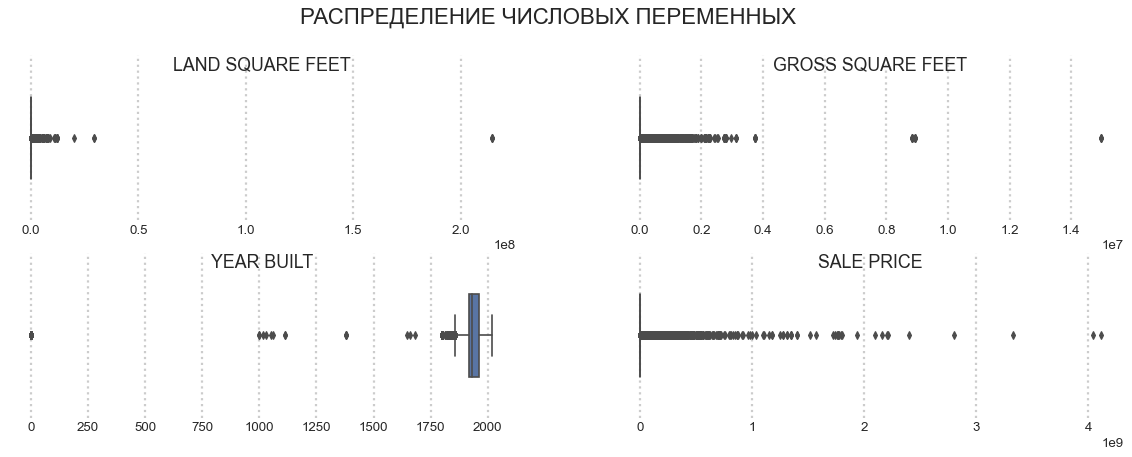

In [16]:
boxplots_numeric()

In [17]:
for column in numeric_columns:
    drop_outliers(df.loc[:, column])

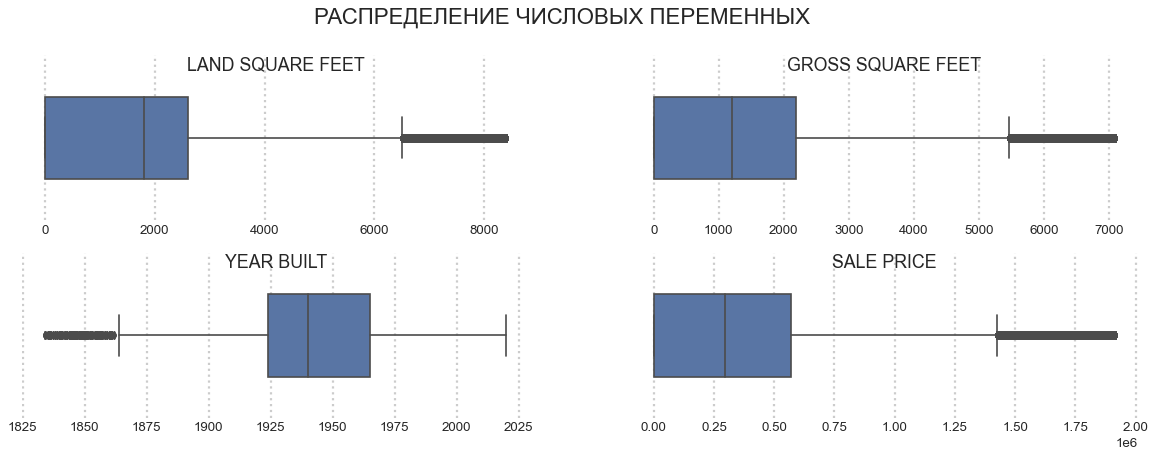

In [18]:
boxplots_numeric()

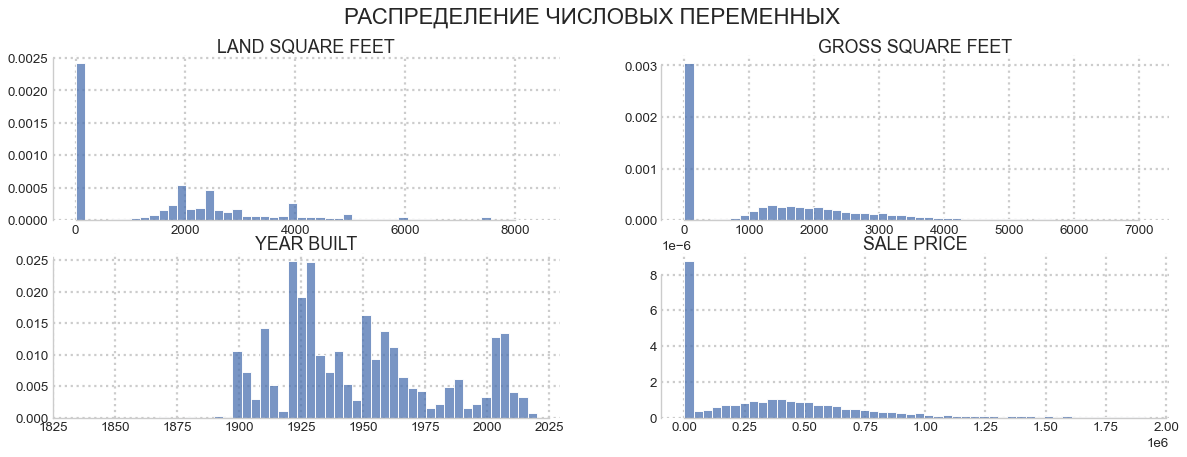

In [19]:
hist_numeric()

In [20]:
df.loc[:,'LAND SQUARE FEET'].mask(df.loc[:,'LAND SQUARE FEET'] < 1000, inplace=True)
df.loc[:,'GROSS SQUARE FEET'].mask(df.loc[:,'GROSS SQUARE FEET'] < 500, inplace=True)
df.loc[:,'SALE PRICE'].mask(df.loc[:,'SALE PRICE'] < 1e4, inplace=True)

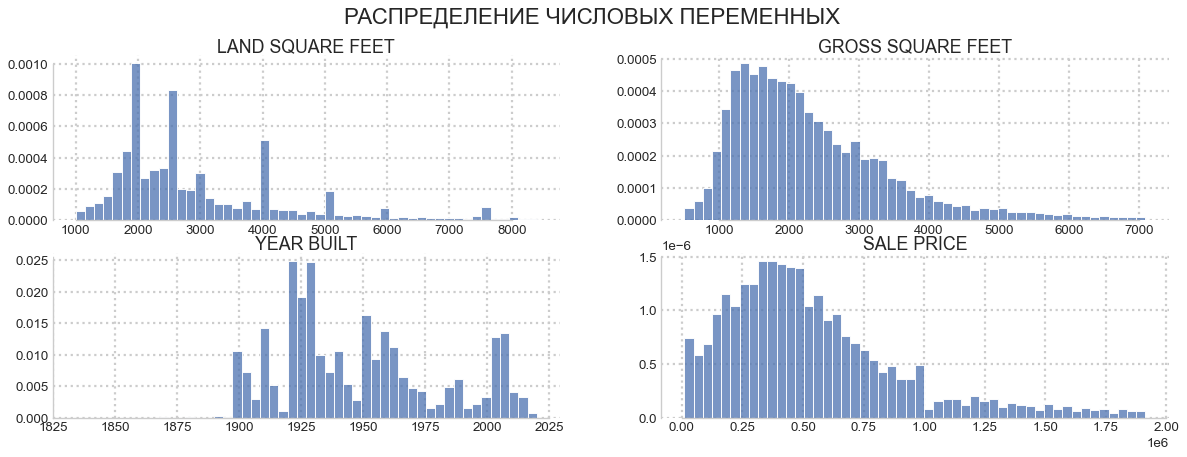

In [21]:
hist_numeric()

### Обработка пропусков

In [22]:
def typeing_features(df, category_columns=category_columns, numeric_columns=numeric_columns):
    df.dropna(how='any', inplace=True)
    df.loc[:, category_columns] = df.loc[:, category_columns].astype('object')
    df.loc[:, numeric_columns] = df.loc[:, numeric_columns].astype('int64')

In [23]:
def feature_editing_1(df):
    df['BOROUGH'] = df['BOROUGH'].apply(lambda x: str(x))
    df['ZIP CODE'] = df['ZIP CODE'].apply(lambda x: None if len(str(x)) != 7 else str(x))
    df.dropna(how='any', inplace=True)
    df['ZIP CODE'] = df['ZIP CODE'].apply(lambda x: str(x).split('.')[0])

In [24]:
df.isna().sum()

BOROUGH                         0
NEIGHBORHOOD                    0
BUILDING CLASS CATEGORY         0
ADDRESS                         0
ZIP CODE                       16
LAND SQUARE FEET           672005
GROSS SQUARE FEET          710524
YEAR BUILT                 160958
SALE PRICE                 547931
SALE DATE                       0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527561 entries, 647963 to 77285
Data columns (total 10 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   BOROUGH                  1527561 non-null  int64         
 1   NEIGHBORHOOD             1527561 non-null  object        
 2   BUILDING CLASS CATEGORY  1527561 non-null  object        
 3   ADDRESS                  1527561 non-null  object        
 4   ZIP CODE                 1527545 non-null  float64       
 5   LAND SQUARE FEET         855556 non-null   float64       
 6   GROSS SQUARE FEET        817037 non-null   float64       
 7   YEAR BUILT               1366603 non-null  float64       
 8   SALE PRICE               979630 non-null   float64       
 9   SALE DATE                1527561 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 128.2+ MB


In [26]:
typeing_features(df)
feature_editing_1(df)

In [27]:
display(HTML(f'Количество пропущенных значений в таблице: <code>{df.isna().sum().sum()}</code>'))
display(HTML(f'Не пустых строк: <code>{df.shape[0]:,.0f}</code>, столбцов: <code>{df.shape[1]}</code>'))

### Анализ категориальных переменных

In [28]:
def del_whitespace_1(x):
    new_x=[]
    for i in x.split(' ')[1:]:
        if len(i) > 0:
            new_x.append(i)
    return ' '.join(new_x)

In [29]:
def del_whitespace_2(x):
    new_x=[]
    for i in x.split(' '):
        if len(i) > 0:
            new_x.append(i)
    return ' '.join(new_x)

In [30]:
def feature_editing_2(df, category_columns=category_columns):
    df[category_columns] = df[category_columns].apply(lambda x: x.apply(lambda x: x.strip().lower()))

    df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].apply(del_whitespace_1).str.replace('/',' ')
    df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].str.replace('-',' ').str.replace('/',' ').str.replace('.',' ').apply(del_whitespace_2)
    df['ADDRESS'] = df['ADDRESS'].apply(del_whitespace_2).str.replace('-',' ').apply(del_whitespace_1)

In [31]:
df[category_columns].describe().loc['unique',:].to_frame()

,unique
BOROUGH,5
NEIGHBORHOOD,486
BUILDING CLASS CATEGORY,80
ADDRESS,382607
ZIP CODE,177


In [32]:
feature_editing_2(df)

In [33]:
df.drop_duplicates(inplace=True)#, ignore_index=True

In [34]:
df[category_columns].describe().loc['unique',:].to_frame()

,unique
BOROUGH,5
NEIGHBORHOOD,251
BUILDING CLASS CATEGORY,39
ADDRESS,80785
ZIP CODE,177


## Анализ целевого признака

In [35]:
def extruct_year(df):
    df['SALE DATE YEAR'] = df['SALE DATE'].dt.year

In [36]:
def typeing_features_2(df, category_columns=category_columns, numeric_columns=numeric_columns):
    df[numeric_columns] = df[numeric_columns].astype('int64')
    df[category_columns] = df[category_columns].astype('category')

In [37]:
extruct_year(df)
mean_price_per_year_series = df.groupby('SALE DATE YEAR')['SALE PRICE'].mean()

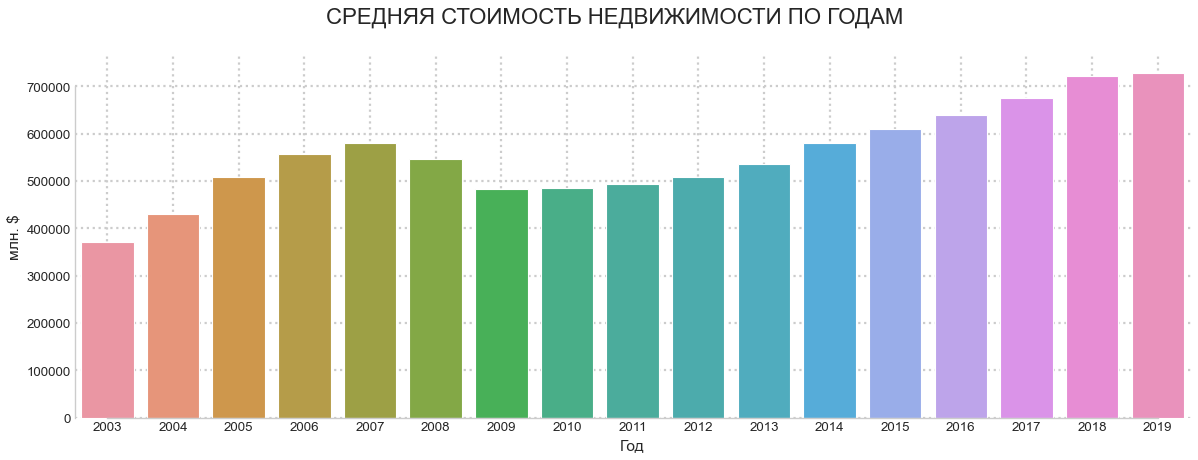

In [38]:
fig = plt.figure()
fig.suptitle(f'Средняя стоимость недвижимости по годам'.upper(), position=(0.5,0.98))
sns.barplot(x=mean_price_per_year_series.index, y=mean_price_per_year_series)#
sns.despine(top=True, right=True, left=False, bottom=False, trim=True)
plt.ylabel('млн. $')
plt.xlabel('Год')
plt.grid(True, axis='both', linestyle=':', linewidth=2)
plt.tick_params(direction='in', length=0)

In [39]:
newest_df = df[df['SALE DATE YEAR'] > 2017].reset_index(drop=True).copy()
typeing_features_2(newest_df)
#newest_df[numeric_columns] = newest_df[numeric_columns].astype('int64')
#newest_df[category_columns] = newest_df[category_columns].astype('category')

display(HTML(f'В отобранном датасете строк: <code>{newest_df.shape[0]:,.0f}</code>, столбцов: <code>{newest_df.shape[1]}</code>'))

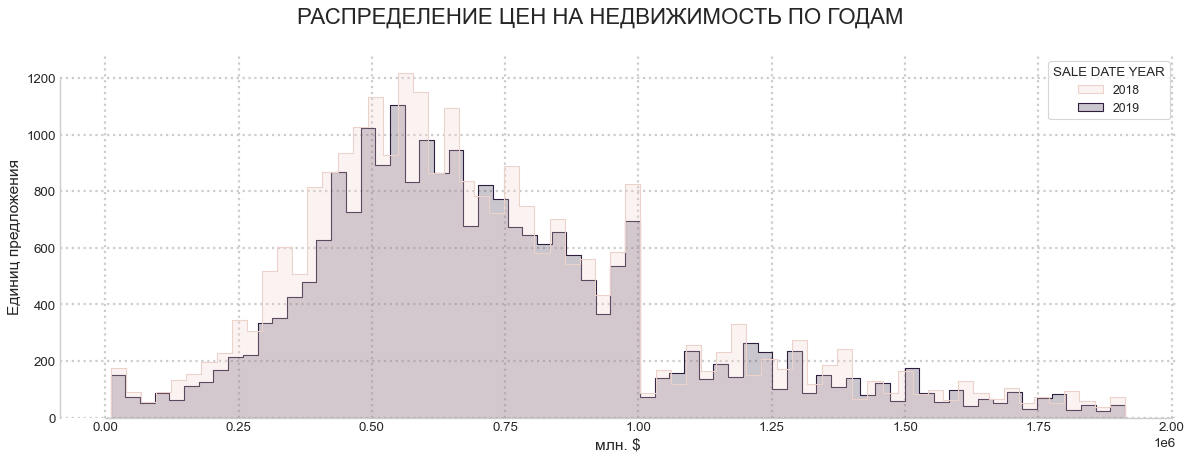

In [40]:
sns.color_palette()
fig = plt.figure()
fig.suptitle(f'Распределение цен на недвижимость по годам'.upper(), position=(0.5,0.98))
sns.histplot(data=newest_df, x='SALE PRICE', hue='SALE DATE YEAR', kde=False, common_bins=False, element="step")#
sns.despine(top=True, right=True, left=False, bottom=False, trim=True)
plt.ylabel('Единиц предложения')
plt.xlabel('млн. $')
plt.grid(True, axis='both', linestyle=':', linewidth=2)
plt.tick_params(direction='in', length=0)

## Разработка модели

### Разбитие на выборки

#### Features & Target

In [41]:
drop_columns=['SALE PRICE', 'BOROUGH', 'ADDRESS', 'SALE DATE', 'SALE DATE YEAR']#
features = newest_df.drop(columns=drop_columns)
target = newest_df['SALE PRICE']

#### Train & Test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

### Подбор гипперпараметров модели

In [43]:
cat_features = X_train.select_dtypes('category').columns.to_list()

In [44]:
best_score = 1e9
iterations, learning_r = 0, 0
start_time = time.time()

for i in np.arange(245, 249, 1):
    for j in np.arange(0.87, 0.90, 0.01):
        model = CatBoostRegressor(iterations=i,
                                  learning_rate=j,
                                  max_depth=3,
                                  cat_features=cat_features,
                                  verbose=False,
                                  random_state=12345,
                                  loss_function='RMSE',
                                 )

        n_scores = cross_val_score(model,
                                   X_train,
                                   y_train,
                                   scoring='neg_root_mean_squared_error',
                                   cv=5,
                                   n_jobs=-1,
                                   error_score='raise'
                                  )

        score = np.mean(np.abs(n_scores))

        if score < best_score:
            best_score = score
            iterations = i
            learning_r = j

fit_time = time.time() - start_time

display(HTML(f'<b>Гипперпараметры iterations:</b> <code>{iterations}</code>, <b>learning_rate:</b> <code>{learning_r:,.3f}</code>'))
display(HTML(f'<b>Лучшее RMSE: </b> <code>{best_score:,.1f}</code>'))
display(HTML(f'<b>Время обучения: </b> <code>{fit_time:,.2f}</code> c'))

## Тестирование модели

In [45]:
model = CatBoostRegressor(iterations=iterations,
                          learning_rate=learning_r,
                          max_depth=3,
                          cat_features=cat_features,
                          verbose=False,
                          random_state=12345,
                         )
model.fit(X_train, y_train)
score_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
score_mae = mean_absolute_error(y_test, model.predict(X_test))

display(HTML(f'<b>RMSE на тестовой выборке: </b> <code>{score_rmse:,.1f}</code>'))
display(HTML(f'<b>MAE на тестовой выборке: </b> <code>{score_mae:,.1f}</code>'))

## Сравнение результатов с baseline

In [46]:
def baseline_prediction(df, X):
    return df.loc[X.index,:].groupby(['BOROUGH','ZIP CODE','SALE DATE YEAR'])['SALE PRICE'].transform('mean')

In [47]:
dummy_prediction = baseline_prediction(newest_df, X_test)

score_rmse_baseline = mean_squared_error(y_test, dummy_prediction, squared=False)
score_mae_baseline = mean_absolute_error(y_test, dummy_prediction)

display(HTML(f'<b>RMSE для baseline модели на тестовой выборке: </b> <code>{score_rmse_baseline:,.1f}</code>'))
display(HTML(f'<b>MAE для baseline на тестовой выборке: </b> <code>{score_mae_baseline:,.1f}</code>'))

## Оценка экономического эффекта

Платформа берет комиссию в случае успешной сделки, допустим, в размере $0.1 \%$ от суммы сделки (то есть цены за недвижимость). В датасете представлены исторические данные о совершенных сделках, поэтому в случае, когда мы даем предсказание о цене на объекты недвижимости, которые в том числе не будут проданы, необходимо определить долю проданных объектов среди всех представленных на рынке. Допустим, на платформе за прогнозируемый период удается реализовать $70\%$ объявлений. Тогда экономическая выгода может быть посчитана по формуле:
$$ Q = \sum_{n=1}^{N} \alpha \cdot S_{n} $$
где $Q$ - суммарная выручка платформы,  
$S_{n}$ - стоимость $n$-ного объекта недвижимости,  
$\alpha$ - риелторская $0.1 \%$ комиссия от суммы сделки,  
$N$ - случайная $70\%$ выборка объектов из массива оцениваемых данных о недвижимости

In [48]:
a_coeff = 0.1
frac = 0.7

In [49]:
def revenue(X, y, df, key:bool, f=frac, a=a_coeff):
    revenue_true = (y.sample(frac=f, random_state=12345) * a).sum()
    if key:
        revenue_predict = (pd.Series(model.predict(X), index=X.index).sample(frac=f, random_state=12345) * a).sum()
    else:
        revenue_predict = (baseline_prediction(df, X).sample(frac=f, random_state=12345) * a).sum()
    revenue_ratio = np.abs(revenue_predict - revenue_true) / revenue_true
    
    display(HTML(f'<b>Выручка платформы:</b>'))
    display(HTML(f'Без использования модели: <code>{revenue_true:,.2f}</code>'))
    display(HTML(f'С использованием модели: <code>{revenue_predict:,.2f}</code>'))
    display(HTML(f"{'Увеличение на' if revenue_predict > revenue_true else 'Уменьшение на'} <code>{revenue_ratio:,.2%} </code>"))

In [50]:
test_data = df_test.copy()

for column in ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']:
    drop_outliers(test_data.loc[:, column])
test_data.loc[:,'LAND SQUARE FEET'].mask(test_data.loc[:,'LAND SQUARE FEET'] < 1000, inplace=True)
test_data.loc[:,'GROSS SQUARE FEET'].mask(test_data.loc[:,'GROSS SQUARE FEET'] < 500, inplace=True)

typeing_features(test_data)
feature_editing_1(test_data)
feature_editing_2(test_data)
extruct_year(test_data)
typeing_features_2(test_data)

test_data = test_data[test_data['SALE DATE YEAR'] > 2017]
test_data_X = test_data.drop(columns=drop_columns)
test_data_y = test_data['SALE PRICE']

### Для обученной модели:

In [51]:
revenue(test_data_X, test_data_y, test_data, True)

### Для baseline модели:

In [52]:
revenue(test_data_X, test_data_y, test_data, False)

### Зависимость оценки эффекта от качества модели

Допустим, что выручка платформы обратно пропорциональна метрике, тогда:

$$  \frac{REVENUE_{model}}{REVENUE_{baseline}} = \frac{RMSE_{baseline}}{RMSE_{model}} $$

$$  \frac{31,954,183.02}{27,781,948.69} = \frac{268,983.9}{233,085.7} $$

$$ 1.1501 \approx 1.1540 $$

А это значит, что с улучшением метрики на `1 %` выручка также увеличивается на `1 %`